In [3]:
import env
import utilities as utils

from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from numpy import linspace, loadtxt, ones, convolve
from sklearn.ensemble import IsolationForest
import numpy as np
import pandas as pd
import collections
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
# style.use('fivethirtyeight')
%matplotlib inline

pd.plotting.register_matplotlib_converters()

## Acquire

In [102]:
cols = ['date', 'time', 'url', 'user_id', 'cohort_id', 'ip_address']

log_df = pd.read_csv(env.data_path + "anonymized-curriculum-access.txt.gz", compression="gzip",\
                     header=None, sep="\s", names=cols, usecols=[0, 2, 3, 4, 5])

log_df.head()

,date,url,user_id,cohort_id,ip_address
0,2018-01-26,/,1,8.0,97.105.19.61
1,2018-01-26,java-ii,1,8.0,97.105.19.61
2,2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61


In [7]:
# set index to the date
log_df = utils.set_index_to_datetime(log_df, 'date')

In [77]:
# resample to get daily visits
visits = log_df.url.resample("D").count()

## Exponential moving average
* Differs from a simple moving average since it weighs the more recent points more heavily
    * A simple moving average weighs all points evenly
* This weight reduces the lag effect seen with a simple moving average

In [11]:
# Different spans for EMA
ema_7d = visits.ewm(span=7).mean()
ema_7d.head()

date
2018-01-26    572.000000
2018-01-27    376.571429
2018-01-28    287.243243
2018-01-29    485.737143
2018-01-30    540.235595
Freq: D, Name: url, dtype: float64

In [12]:
ema_14d = visits.ewm(span=14).mean()
ema_14d.head()

date
2018-01-26    572.000000
2018-01-27    388.785714
2018-01-28    305.208829
2018-01-29    465.757252
2018-01-30    514.347700
Freq: D, Name: url, dtype: float64

In [13]:
ema_30d = visits.ewm(span=30).mean()
ema_30d.head()

date
2018-01-26    572.000000
2018-01-27    395.300000
2018-01-28    315.139578
2018-01-29    457.002386
2018-01-30    501.369064
Freq: D, Name: url, dtype: float64

In [14]:
ema_90d = visits.ewm(span=90).mean()
ema_90d.head()

date
2018-01-26    572.000000
2018-01-27    399.100000
2018-01-28    321.030081
2018-01-29    452.545042
2018-01-30    494.228442
Freq: D, Name: url, dtype: float64

The first value for EMA is the same in all the different spans because the EMA is computed with all the values available and since there is only 1 value available after the first observation, all the weight is assigned to that value, resulting in the same EMA for 1/26 on all the different spans.

In [26]:
def visualize_moving_averages(averages_list, averages_labels, time_series, y_label, figure_size=(12, 6)):
    """
    Generates a figure showing the original time series data and the different moving averages
    
    Parameters
    ----------
    averages_list : list[series]
        A list containing the different series with moving averages
    averages_labels : list[str]
        A list containing the labels for each of the moving averages (positions should match the averages_list\
        for accurate labeling)
    time_series : series
        The series with a time index containing the original data
    y_label : str
        The name for the y-axis
    figure_size : tuple(int, int)
        A tuple with the dimensions for the figure (default = (12, 6))

    Returns
    -------
    None
    """
    
    fig, ax = plt.subplots(figsize=figure_size)
    
    ax.plot(time_series.index, time_series, label=y_label, alpha=.5)
    
    for (ema, label) in zip(averages_list, averages_labels):
        ax.plot(time_series.index, ema, label=str(label))
        ax.legend(loc="best")
        ax.set_ylabel(y_label)
        
    plt.show()

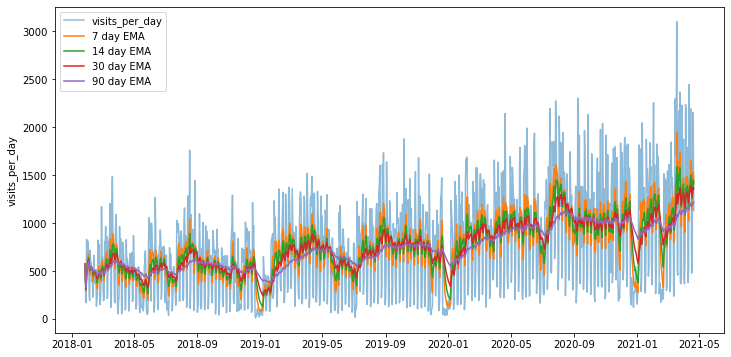

In [27]:
emas = [ema_7d, ema_14d, ema_30d, ema_90d]
labels = ['7 day EMA', '14 day EMA', '30 day EMA', '90 day EMA']

visualize_ema(emas, labels, visits, 'visits_per_day')

## Bollinger Bands and %b
* The midband is the EMA with a span of your choosing
* The standard deviation of the midband is calculated in order to determine the upper and lower bands
    * The upper and lower bands are determined by multiplying the standard deviation by a factor of K (you choose this value!)

In [37]:
def generate_bollinger_bands(time_series, ema_span, k_factor):
    """
    Generates a dataframe with the lower, mid, and upper Bollinger bands of a time series.
    
    Parameters
    ----------
    time_series : series
        The series with a time index containing the original data
    ema_span : int
        The period of time used to calculate the EMA
    k_factor : int
        The multiplier for the standard deviation used to calculate the upper and lower bands

    Returns
    -------
    DataFrame
        A dataframe containing the values of the lower, mid, and upper bands
    """
    
    stdev = time_series.ewm(span=ema_span).std()
    
    mid_band = time_series.ewm(span=ema_span).mean()
    upper_band = mid_band + (stdev * k_factor)
    lower_band = mid_band - (stdev * k_factor)
    
    boll_bands = pd.concat([lower_band, mid_band, upper_band], axis=1)
    boll_bands.columns = ['lower_band', 'mid_band', 'upper_band']
    
    return boll_bands

In [38]:
# Calculate the bands
boll_bands = generate_bollinger_bands(visits, 30, 3)

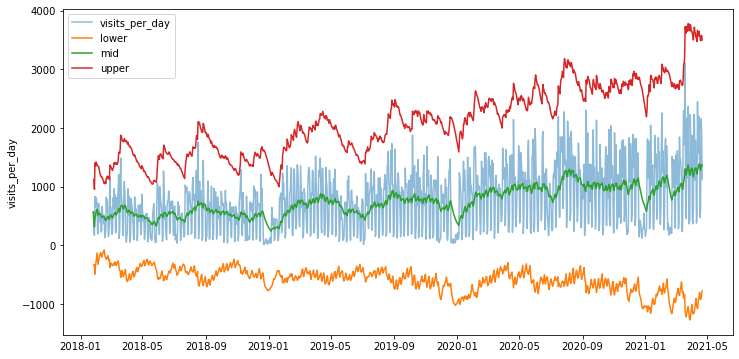

In [78]:
# Even though this function was used to visualize EMAs, it can be used in this situation as well.
visualize_moving_averages([boll_bands.lower_band, boll_bands.mid_band, boll_bands.upper_band],\
                          ['lower', 'mid', 'upper'], visits, "visits_per_day")

* The %b (percent bandwith) is an indicator of the position of the current observation in relation to the Bollinger bands
    1. if %b == 1, the current observation is equal to the upper band value
        * above 1 is above the upper band
    2. if %b == .5, the current observation is equal to the middle band value
        * above .5 and < 1, is between the middle and upper bands
        * below .5 and > 0, is between the middle and lower bands
    3. if %b == 0, the current observation is equal to the lower band value
        * below 0 is below the lower band

In [79]:
# 
def calculate_pct_bandwith(observations, upper_band, lower_band):
    """
    Generates a series with the percent bandwith of each observation in a time series.
    
    Parameters
    ----------
    observations : series
        The series containing the values at each point in time
    upper_band : series
        The series containing the upper band values
    lower_band : series
        The series containing the lower band values

    Returns
    -------
    Series
        A series containing the percent bandwith at each point in time
    """
    
    pct_b = (observations - lower_band) / (upper_band - lower_band)
    pct_b = pct_b.rename("pct_b")
    
    return pct_b

In [80]:
# Adding the boll_bands to the original dataframe
visits = pd.concat([visits, boll_bands], axis=1)

In [82]:
pct_b = calculate_pct_bandwith(visits.url, visits.upper_band, visits.lower_band)

In [83]:
# Add pct_b to the original dataframe
visits = pd.concat([visits, pct_b], axis=1)

In [86]:
visits

,url,lower_band,mid_band,upper_band,pct_b
date,,,,,
2018-01-26,572,NaN,572.000000,NaN,NaN
2018-01-27,230,-330.191557,395.300000,1120.791557,0.386077
2018-01-28,170,-326.494835,315.139578,956.773991,0.386899
2018-01-29,830,-492.401124,457.002386,1406.405897,0.696438
2018-01-30,652,-352.070116,501.369064,1354.808245,0.588249
...,...,...,...,...,...
2021-04-17,478,-894.858492,1325.179115,3545.216722,0.309197
2021-04-18,659,-922.334061,1282.199817,3486.733695,0.358655
2021-04-19,2156,-891.999913,1338.574023,3569.147958,0.683232


## Put it all together

In [87]:
def acquire_log_data(file_name, cols):
    """
    
    """
    
    return pd.read_csv(env.data_path + file_name, compression="gzip",\
                     header=None, sep="\s", names=cols, usecols=[0, 2, 3, 4, 5])

In [88]:
def prep_log_data_by_user(df, user):
    """
    
    """

    user_df = df[df.user_id == user]
    user_df = utils.set_index_to_datetime(user_df, 'date')
    
    return user_df.url.resample("D").count()

In [99]:
def find_anomalies(df, user, span, weight,):
    """
    
    """
    visits = prep_log_data_by_user(df, user)
    bands = generate_bollinger_bands(visits, span, weight)
    pct_b = calculate_pct_bandwith(visits, bands.upper_band, bands.lower_band)
    
    user_df = pd.concat([visits, bands, pct_b], axis=1)
    
    return user_df[user_df.pct_b > 1]

In [90]:
# get my activity
dalviola_visits_df = prep_log_data_by_user(acquire_log_data("anonymized-curriculum-access.txt.gz", \
                                       ['date', 'time', 'url', 'user_id', 'cohort_id', 'ip_address']),\
                     143)

In [91]:
bands = generate_bollinger_bands(dalviola_visits_df, 30, 3)

In [94]:
dalviola_visits_df = pd.concat([dalviola_visits_df, bands], axis=1)

In [95]:
pct_b = calculate_pct_bandwith(dalviola_visits_df.url, dalviola_visits_df.upper_band, dalviola_visits_df.lower_band)

In [97]:
dalviola_visits_df = pd.concat([dalviola_visits_df, pct_b], axis=1)

In [100]:
# Anomalies found step-by-step
dalviola_visits_df[dalviola_visits_df.pct_b > 1]

,url,lower_band,mid_band,upper_band,pct_b
date,,,,,
2018-05-06,4,-3.144832,0.335595,3.816021,1.026431
2020-12-07,1,-0.685094,0.064516,0.814126,1.123981
2020-12-08,27,-18.401823,1.802289,22.006402,1.123579
2020-12-09,52,-37.359486,5.040851,47.441188,1.053759
2021-02-22,31,-20.234306,5.004388,30.243082,1.014995


In [103]:
# Verifying my function works
find_anomalies(log_df, 143, 30, 3)

,url,lower_band,mid_band,upper_band,pct_b
date,,,,,
2018-05-06,4,-3.144832,0.335595,3.816021,1.026431
2020-12-07,1,-0.685094,0.064516,0.814126,1.123981
2020-12-08,27,-18.401823,1.802289,22.006402,1.123579
2020-12-09,52,-37.359486,5.040851,47.441188,1.053759
2021-02-22,31,-20.234306,5.004388,30.243082,1.014995
